In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%tensorflow_version 1.x
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, Lambda, BatchNormalization
from tensorflow.keras.layers import concatenate, Add, Conv2DTranspose
from tensorflow.keras.activations import softmax
import numpy as np
from math import floor

from mir_eval.separation import bss_eval_sources
import librosa
import librosa.display
import IPython.display
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.stats import multivariate_normal
from math import log

sys.path.append('/content/gdrive/My Drive/Nagy házi/')
from audio_masking import *

In [0]:
model_weights_path = "/content/gdrive/My Drive/Nagy házi/unet_softmax.hdf5"

## Importing the model

In [0]:
S = 2   # Number of speakers
F = 257 # Number of STFT frequency bins
T = 431 # Number of STFT time bins
SFT=S*F*T

input_shape = (F,T,1)

In [5]:
def softMaxAxisLast(x):
    return softmax(x,axis=-1)

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = ZeroPadding2D(((0,0),(0,1)))(u6)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = ZeroPadding2D(((0,0),(0,1)))(u7)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = ZeroPadding2D(((0,0),(0,1)))(u8)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = ZeroPadding2D(((0,1),(0,1)))(u9)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(2, (1, 1), activation='relu') (c9)
    outputs = Activation(softMaxAxisLast)(outputs)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

input_stft = Input(input_shape, name = 'mixed_stft')
model = get_unet(input_stft,
                 n_filters = 16,
                 batchnorm=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.load_weights(model_weights_path)

## Signal Distortion Ratio (SDR) calculation

Load test data prepared previously, which is separate from training and validation data:

In [0]:
testPairs = pd.read_csv('/content/gdrive/My Drive/Nagy házi/audiobooks/train_data/test_pair_indices.csv')

In [8]:
len(testPairs)

507

Calculate the average SDR value of the separations using our model. Two reference values are also calculated: SDR of the original, mixed (unseparated) signal, and the SDR that could be achievable using Ideal Ratio Masks, which is considered the oracle.

In [26]:
sdr_model = 0
sdr_mixed = 0
sdr_irm = 0
percentage = 0
for i in range(len(testPairs)):
  files = list(testPairs.iloc[i][1:])
  # Frequency domain
  X1 = np.load(files[0], allow_pickle=False, fix_imports=True)
  X2 = np.load(files[1], allow_pickle=False, fix_imports=True)
  Y = X1 + X2
  YAbs = np.abs(Y)
  testMs = model.predict(np.expand_dims(np.atleast_3d(YAbs), 0))
  [X1pred, X2pred] = reconstructSpectrum([testMs[0][...,0],testMs[0][...,1]], Y)
  testMsIRM = IRM([X1, X2], Y)
  [X1IRM, X2IRM] = reconstructSpectrum([testMsIRM[0],testMsIRM[1]], Y)
  
  # Time domain
  x1 = librosa.istft((X1), hop_length=256)
  x2 = librosa.istft((X2), hop_length=256)
  x1pred = librosa.istft((X1pred), hop_length=256)
  x2pred = librosa.istft((X2pred), hop_length=256)
  x1irm = librosa.istft((X1IRM), hop_length=256)
  x2irm = librosa.istft((X2IRM), hop_length=256)
  y = librosa.istft((Y*0.5), hop_length=256)
  # SDR
  sdr_model += bss_eval_sources(np.array([x1,x2]),
                                np.array([x1pred,x2pred]))[0]
  sdr_mixed += bss_eval_sources(np.array([x1,x2]),
                                np.array([y,y]))[0]
  sdr_irm += bss_eval_sources(np.array([x1,x2]),
                              np.array([x1irm,x2irm]))[0]
  
  if floor(i/len(testPairs)*100) > percentage:
    percentage = floor(i/len(testPairs)*100)
    print("\r", str(percentage)+'%', end="")

print(sdr_model)
sdr_model = np.mean(sdr_model)/len(testPairs)
sdr_mixed = np.mean(sdr_mixed)/len(testPairs)
sdr_irm = np.mean(sdr_irm)/len(testPairs)
print("\r", "", end="")
print('Average SDR on test set with current model: {0:2.2f} dB'.format(sdr_model))
print('Reference SDR on test set with original mixed signal: {0:2.2f} dB'.format(sdr_mixed))
print('Reference SDR on test set with ideal ratio masks: {0:2.2f} dB'.format(sdr_irm))

 99%[4746.53717643 4622.3183616 ]
 Average SDR on test set with current model: 9.24 dB
Reference SDR on test set with original mixed signal: 0.12 dB
Reference SDR on test set with ideal ratio masks: 12.02 dB


Our model seems to perform quite well according to this metric, while there is still room for improvement. This SDR value however cannot be compared to those from other studies, since we used our own dataset.

Below is an example selected randomly from the test dataset, for subjective evaluation.

## Demonstration of speech separation of a 30 sec signal

A 30 seconds long mixed signal is split into 5 s segments, which are then separated using our model. Due to the permutation-invariant training, a speaker-tracing algorithm based on generalized log likelihood calculation is also implemented and used after the separation.

In [27]:
sampleRate = 22050
baseFolder = "/content/gdrive/My Drive/Nagy házi/audiobooks/"
baseFileNames = [(baseFolder + f) for f in listdir(baseFolder) if isfile(join(baseFolder, f))]
for i in range(len(baseFileNames)):
  print("{}: {}".format(i, baseFileNames[i]))

0: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_03_dickens__Rosalind_Wills.wav
1: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_04_dickens__Joseph_Ugoretz.wav
2: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_13_dickens__Debra_Lynn.wav
3: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_02_dickens__Stewart_Wills.wav
4: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_14_dickens__Zachary_Brewster-Geisz.wav
5: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_15_dickens__Jemma_Blythe.wav
6: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_01_dickens__Kristen_Ferreri.wav
7: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_19_dickens__Graham_Thomsen.wav
8: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_09_dickens__Stuart_Bell.wav
9: /content/gdrive/My Drive/Nagy házi/audiobooks/hardtimes_05_dickens__Paul_Hansen.wav


Load two arbitrary audiobook-segments, split them into 5 seconds long utterances and then perform STFT:

In [0]:
testFiles = [baseFileNames[2], baseFileNames[9]]
startTimes = [122*5, 362*5] # in seconds
duration = 30 # in seconds
testSignals = []
for i in range(len(testFiles)):
  y, sr = librosa.load(testFiles[i], sr = sampleRate)
  y = y[startTimes[i]*sr:(startTimes[i]+duration)*sr]
  testSignals.append(y)

In [0]:
testFiles = [baseFileNames[3], baseFileNames[7]]
startTimes = [192, 768] # in seconds
duration = 30 # in seconds
testSignals = []
for i in range(len(testFiles)):
  y, sr = librosa.load(testFiles[i], sr = sampleRate)
  y = y[startTimes[i]*sr:(startTimes[i]+duration)*sr]
  testSignals.append(y)

In [0]:
utteranceLength = 5 # in seconds
utteranceLengthInSamples = utteranceLength * sampleRate
# STFT params:
nFFT = 512
hopLength = int(nFFT / 2)
winLength = nFFT

numberOfWholeUtterances = int(duration / utteranceLength)
stftArrays = np.ndarray((S, numberOfWholeUtterances, F, T),
                        dtype=np.complex64)

for i in range(len(testSignals)):
  # Split the sound data
  y = testSignals[i]
  yUtterances = np.split(y[:numberOfWholeUtterances * utteranceLengthInSamples],
                         numberOfWholeUtterances)
  for j in range(len(yUtterances)):
    yu = yUtterances[j]
    stftArrays[i,j,...] = librosa.stft(yu,
                                      n_fft=nFFT,hop_length=hopLength,
                                      win_length=winLength,
                                      window='hann',center=True,
                                      dtype=np.complex64,pad_mode='reflect')

The input of the network are the magnitudes of the mixed utterances:

In [0]:
YSeries = stftArrays.sum(axis=0)
YAbsSeries = np.expand_dims(np.abs(YSeries),axis=-1)

Separation using our model:

In [0]:
maskSeries = model.predict(YAbsSeries)

Reverse transform into the time domain:

In [0]:
xSeparatedSeries = np.ndarray((numberOfWholeUtterances, utteranceLengthInSamples, S))
y = np.ndarray((numberOfWholeUtterances, utteranceLengthInSamples))
for i in range(len(maskSeries)):
  a = np.array(reconstructSpectrum([maskSeries[i,...,0],maskSeries[i,...,1]],YSeries[i]))
  x1 = librosa.istft(a[0], hop_length=hopLength, length=utteranceLengthInSamples)
  x2 = librosa.istft(a[1], hop_length=hopLength, length=utteranceLengthInSamples)
  y[i] = librosa.istft(YSeries[i], hop_length=hopLength, length=utteranceLengthInSamples)
  xSeparatedSeries[i] = np.transpose(np.array([x1,x2]))

Before concatenating the utterances, we need to perform speaker tracing. Below is an implementation of a speaker-tracing algorithm based on the clustering measure of Lilt and Kubala, 2004. We used 20-dimensional MFCC vectors as feature vectors to calculate the negative generalized log likelihoods during clustering.

In [0]:
def logL(signals, gaussianModel=None):
  # Log likelihood with multivariate Gaussian distribution
  # Since the likelihood is very small, it is better to calculate
  # everything using the log likelihoods.
  if signals.ndim is 1:
    # Input is a single feature vector
    if gaussianModel is None:
      raise ValueError('Gaussian model needs to be provided for single feature vector.') 
    else:
      return multivariate_normal.logpdf(signals,
                                        mean=gaussianModel[0],
                                        cov=gaussianModel[1])
  else:
    # Input is a set of feature vectors
    gM = [np.mean(signals, axis=1),np.cov(signals)]
    Lsum = 0
    for column in np.transpose(signals):
      Lsum += logL(column, gaussianModel=gM)
    return Lsum

def GLR(s1, s2):
  # Inputs are feature vectors.
  # Log likelihoods are used, but calculation is based
  # on Lilt, Kubala 2004.
  # Returned value is -log GLR, to make it more distance-like
  sc = np.concatenate((s1, s2),axis=1)
  lc = logL(sc)
  l1 = logL(s1)
  l2 = logL(s2)
  return -(lc - l1 - l2)

def speakerSimilarity(signal1, signal2, sampleRate=22050, n_mfcc=20):
  # Calculate MFCC feature vectors
  mfcc1 = librosa.feature.mfcc(y=signal1, sr=sampleRate, n_mfcc=n_mfcc)
  mfcc2 = librosa.feature.mfcc(y=signal2, sr=sampleRate, n_mfcc=n_mfcc)
  # Similarity is negative log generalized likelihood ratio
  return GLR(mfcc1, mfcc2)

Perform the tracing:

In [35]:
xTracedSeries = np.ndarray(xSeparatedSeries.shape)
xTracedSeries[0] = xSeparatedSeries[0]
for i in range(numberOfWholeUtterances-1):
  previousxs = xTracedSeries[i]
  currentxs = xSeparatedSeries[i+1]
  sameDistance = speakerSimilarity(previousxs[...,0], currentxs[...,0]) + speakerSimilarity(previousxs[...,1], currentxs[...,1])
  switchDistance = speakerSimilarity(previousxs[...,0], currentxs[...,1]) + speakerSimilarity(previousxs[...,1], currentxs[...,0])
  print("Switch distance: {1}, no switch distance: {0}".format(sameDistance,switchDistance))
  if switchDistance < sameDistance:
    print('Outputs switched')
    xTracedSeries[i+1,...,0] = currentxs[...,1]
    xTracedSeries[i+1,...,1] = currentxs[...,0]
  else:
    print('Outputs not switched')
    xTracedSeries[i+1,...] = currentxs

Switch distance: 1821.1183651444953, no switch distance: 1206.5161258319058
Outputs not switched
Switch distance: 1822.4393627546997, no switch distance: 1370.7328767999752
Outputs not switched
Switch distance: 1744.198535629428, no switch distance: 1100.0848876864075
Outputs not switched
Switch distance: 1715.591832483482, no switch distance: 1183.231084457202
Outputs not switched
Switch distance: 1850.3428873483608, no switch distance: 1469.110459952095
Outputs not switched


In [0]:
xTracedConcat = np.transpose(np.concatenate(xTracedSeries, axis=0))
yConcat = np.concatenate(y, axis=0)

Visualization of the example using spectrograms:

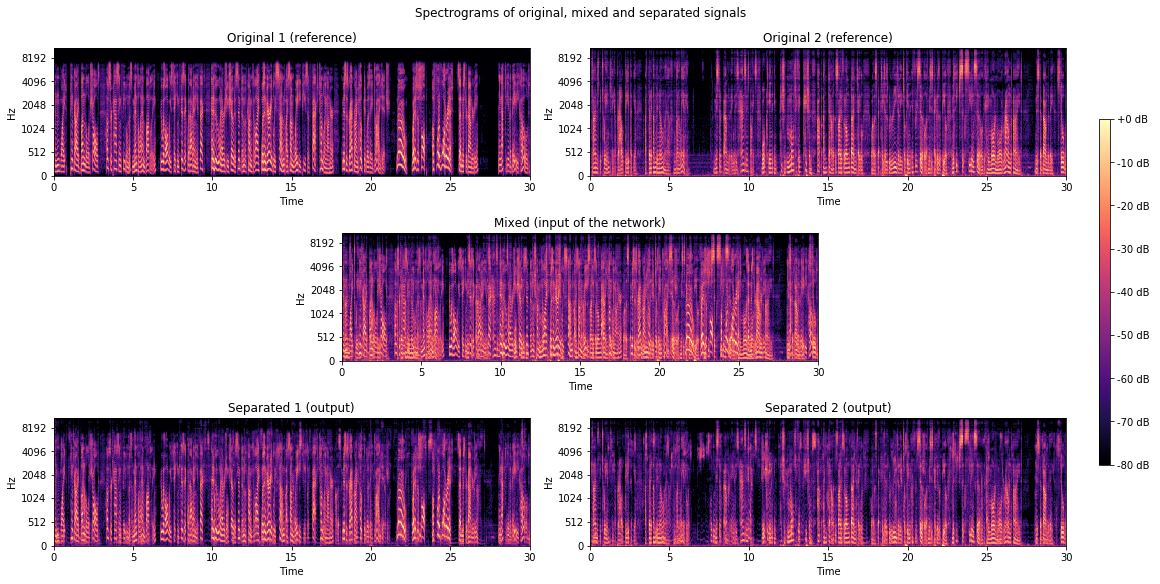

In [37]:
fig = plt.figure(constrained_layout=True, figsize=(16,8))
gs = GridSpec(3, 13,figure=fig)

spectrogram = librosa.feature.melspectrogram(testSignals[0], sr=sampleRate, n_mels=256)
log_S = librosa.power_to_db(spectrogram, ref=np.max)
fig.add_subplot(gs[0,0:6])
librosa.display.specshow(log_S, sr=sampleRate, x_axis='time', y_axis='mel')
plt.title('Original 1 (reference)')

spectrogram = librosa.feature.melspectrogram(testSignals[1], sr=sampleRate, n_mels=256)
log_S = librosa.power_to_db(spectrogram, ref=np.max)
fig.add_subplot(gs[0,6:12])
librosa.display.specshow(log_S, sr=sampleRate, x_axis='time', y_axis='mel')
plt.title('Original 2 (reference)')

spectrogram = librosa.feature.melspectrogram(yConcat, sr=sampleRate, n_mels=256)
log_S = librosa.power_to_db(spectrogram, ref=np.max)
fig.add_subplot(gs[1,3:9])
librosa.display.specshow(log_S, sr=sampleRate, x_axis='time', y_axis='mel')
plt.title('Mixed (input of the network)')

spectrogram = librosa.feature.melspectrogram(xTracedConcat[1], sr=sampleRate, n_mels=256)
log_S = librosa.power_to_db(spectrogram, ref=np.max)
fig.add_subplot(gs[2,0:6])
librosa.display.specshow(log_S, sr=sampleRate, x_axis='time', y_axis='mel')
plt.title('Separated 1 (output)')

spectrogram = librosa.feature.melspectrogram(xTracedConcat[0], sr=sampleRate, n_mels=256)
log_S = librosa.power_to_db(spectrogram, ref=np.max)
fig.add_subplot(gs[2,6:12])
librosa.display.specshow(log_S, sr=sampleRate, x_axis='time', y_axis='mel')
plt.title('Separated 2 (output)')

plt.colorbar(format='%+02.0f dB', cax = plt.axes([0.95, 0.2, 0.01, 0.6]))
plt.suptitle('Spectrograms of original, mixed and separated signals')
plt.savefig('/content/gdrive/My Drive/Nagy házi/model_example_outputs/spectrograms.png')

In [38]:
print("SDR of example: {:2.2f} dB".format(np.mean(bss_eval_sources(np.array([testSignals[0],testSignals[1]]),np.array([xTracedConcat[0],xTracedConcat[1]]))[0])))

SDR of example: 7.87 dB


### Displaying and exporting audio files:




Mixed signal:

In [22]:
IPython.display.Audio(data=yConcat, rate=sampleRate)

Separated signals:

In [23]:
IPython.display.Audio(data=xTracedConcat[0], rate=sampleRate)

In [24]:
IPython.display.Audio(data=xTracedConcat[1], rate=sampleRate)

Exporting WAV files for future reference:

In [0]:
librosa.output.write_wav('/content/gdrive/My Drive/Nagy házi/model_example_outputs/separated1.wav',xTracedConcat[0], sampleRate)
librosa.output.write_wav('/content/gdrive/My Drive/Nagy házi/model_example_outputs/separated2.wav',xTracedConcat[1], sampleRate)
librosa.output.write_wav('/content/gdrive/My Drive/Nagy házi/model_example_outputs/original1.wav',xTracedConcat[1], sampleRate)
librosa.output.write_wav('/content/gdrive/My Drive/Nagy házi/model_example_outputs/original2.wav',xTracedConcat[0], sampleRate)
librosa.output.write_wav('/content/gdrive/My Drive/Nagy házi/model_example_outputs/mixed.wav',yConcat, sampleRate)